Signal Processing Examples for ODSC (May 4, 2018)
===

This notebook contains several examples that accompany the talk *Making the Most of Your Time Series:  Signal 
Processing for Machine Learning Applications*, presented at ODSC East 2018.  Information on the build that's being used to run this notebook:

* Python 2.7 
* *pandas* 0.18.1
* *numpy* 1.11.0
* *scipy* 0.17.1
* *matplotlib* 1.5.1
* (optional) *folium* 0.5.0

I don't expect newer distributions of any of these packages to pose problems, but no guarantees.  

Table of Contents
--
* <a href=#import_load>Import Basic Packages and Load Data </a>
* <a href=#win_med_mean>Windowed Mean and Median Filtering</a> 
* <a href=#fft_stuff>The Fast Fourier Transform (FFT)</a>
* <a href=#butter>Butterworth Filtering </a>

NOTE
--
I'm using my *nav_fusion* kernel right now to load various sensorplay files, but once I find the data I want, I'm just going to pickle it and load that in.

<a id=import_load></a>
Import Basic Packages and Load Data
===

In [1]:
from scipy import signal
import numpy as np
import numpy.fft as fft
import pandas as pd
import matplotlib.pyplot as pl
%matplotlib notebook

#CHANGE PATH BELOW TO LOCAL PATH ON YOUR OWN DEVICE!
accel=pd.read_csv('data/accel.csv',index_col=0)
accel_raw=pd.read_csv('data/accel_raw.csv',index_col=0) 
gyro=pd.read_csv('data/gyro.csv',index_col=0)     
gps=pd.read_csv('data/gps.csv',index_col=0)                 

<a id=win_med_mean></a>
Windowed Mean and Median Filtering
===

To illustrate windowed mean and median filtering, we're going to look at some GPS data for a phone that travelled in a car for approximately 20 minutes.  *gps* is a pandas DataFrame that records several GPS-related quantities in one second intervals:

In [2]:
gps.head(n=10)

,lat,lon,alt,crs,hac,vac,spd,dst,t
0.0,42.406357,-71.074742,4.618099,240.117188,10.0,4.0,0.0,0.0,1510239094000
1.0,42.406357,-71.074742,4.444546,240.117188,10.0,4.0,0.0,0.0,1510239095000
2.0,42.406357,-71.074742,4.424648,240.117188,10.0,4.0,0.0,0.0,1510239096000
3.0,42.406357,-71.074742,4.126949,240.117188,10.0,4.0,0.0,0.0,1510239097000
4.0,42.406357,-71.074742,3.870846,240.117188,10.0,4.0,0.0,0.0,1510239098000
5.0,42.406357,-71.074742,3.538357,240.117188,10.0,4.0,0.0,0.0,1510239099000
6.0,42.406357,-71.074742,3.694546,240.117188,10.0,4.0,0.0,0.0,1510239100000
7.0,42.406357,-71.074742,3.212246,240.117188,10.0,4.0,0.0,0.0,1510239101000
8.0,42.406357,-71.074742,3.433132,240.117188,10.0,4.0,0.0,0.0,1510239102000
9.0,42.406357,-71.074742,3.595913,240.117188,10.0,4.0,0.0,0.0,1510239103000


Not a whole lot going on during the first 10 seconds (speed is 0!).  If we plot the longitude vs. the latitude, 
we can trace out the path taken by the car:

<IPython.core.display.Javascript object>


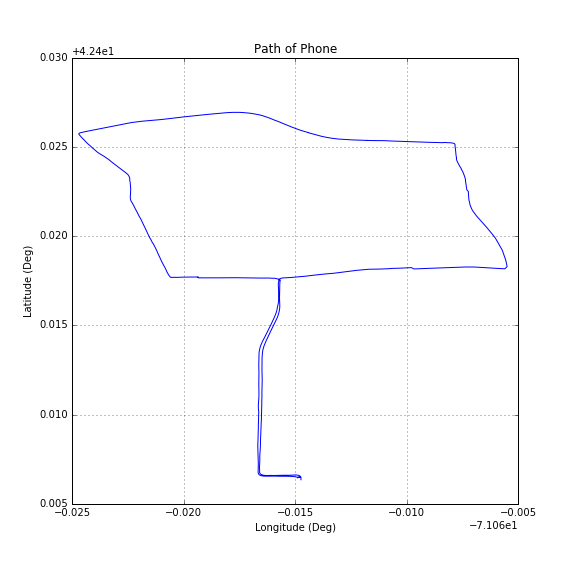

In [3]:
#UNCOMMENT THE CODE BELOW IF YOU HAVE FOLIUM INSTALLED:

# import folium
# from IPython.core.display import display
# map1 = folium.Map(location=[42.417631,-71.075679], zoom_start=14, width="100%", height="100%")
# for ii in range(len(gps)):
#     folium.CircleMarker(location=[gps.lat.iloc[ii], gps.lon.iloc[ii]],
#                         radius=3).add_to(map1)
# display(map1)

pl.figure(figsize=(8,8))
pl.plot(gps.lon,gps.lat)
pl.grid()
pl.title('Path of Phone')
pl.xlabel('Longitude (Deg)')
pl.ylabel('Latitude (Deg)')

We can view the data as a time series by plotting each individual component of the GPS location---latitude, longitude, and altitude---vs. time:

<IPython.core.display.Javascript object>


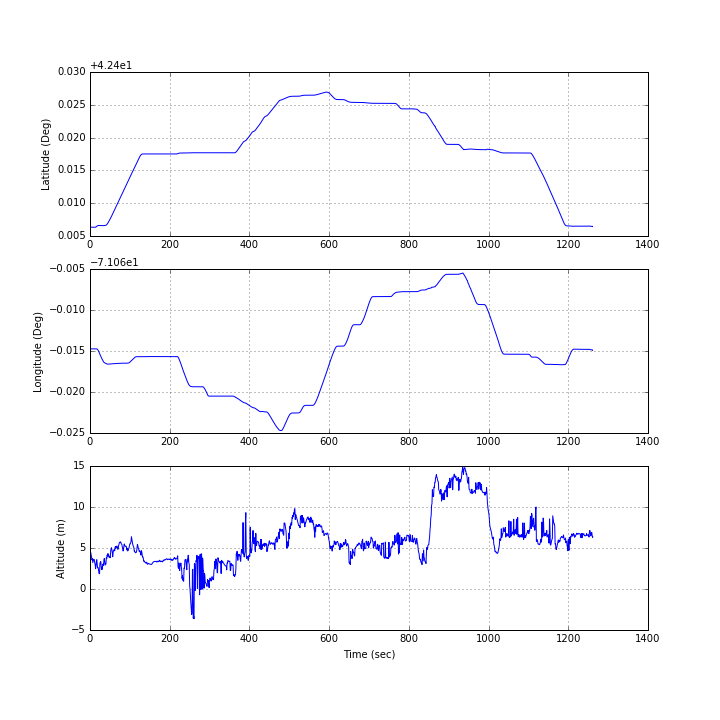

In [4]:
pl.figure(figsize=(10,10))
ax1=pl.subplot(311)
pl.plot(gps.lat)
# pl.title('GPS Latitude')
pl.ylabel('Latitude (Deg)')
pl.grid()

pl.subplot(312,sharex=ax1)
pl.plot(gps.lon)
# pl.title('GPS Longitude')
pl.ylabel('Longitude (Deg)')
pl.grid()

pl.subplot(313,sharex=ax1)
pl.plot(gps.alt)
# pl.title('GPS Altitude')
pl.ylabel('Altitude (m)')
pl.xlabel('Time (sec)')
pl.grid()

Experiment with Rolling Mean/Median Filters on Altitude Data
--

<IPython.core.display.Javascript object>


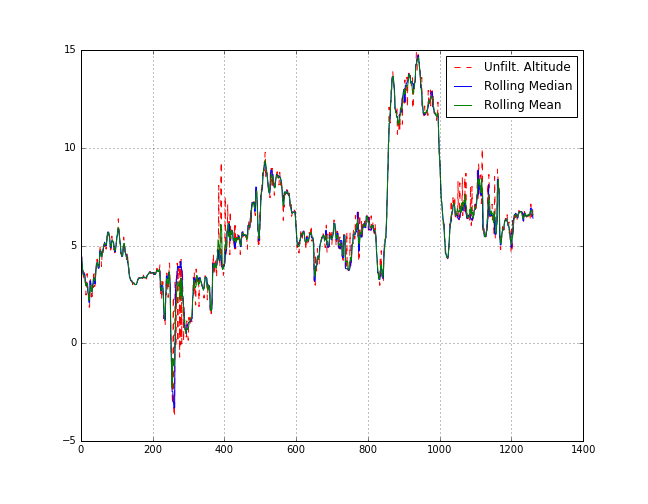

In [5]:
# "win_size" is the length of the window over which we compute the mean/median.  Will look at lengths of 5,11, and 101 
# for demonstration

win_size=5
gps_med_filt=gps.alt.rolling(window=win_size,center=True).median()
gps_mean_filt=gps.alt.rolling(window=win_size,center=True).mean()

pl.figure(figsize=(9,7))
line1,=pl.plot(gps.alt,'--r')
line2,=pl.plot(gps_med_filt,'b')
line3,=pl.plot(gps_mean_filt,'g')
pl.legend([line1,line2,line3],['Unfilt. Altitude','Rolling Median','Rolling Mean'],loc=0)
pl.grid()


<a id=fft_stuff></a>
The Fast Fourier Transform (FFT)
===
We're first going to start off by computing the FFT of the toy example listed in the slides:
$$x(t)=\cos 2\pi t + \frac{1}{2}\cos 4\pi t$$.

If correctly computed, we should see spikes at 1 Hz and 2 Hz and no energy elsewhere.  

<IPython.core.display.Javascript object>


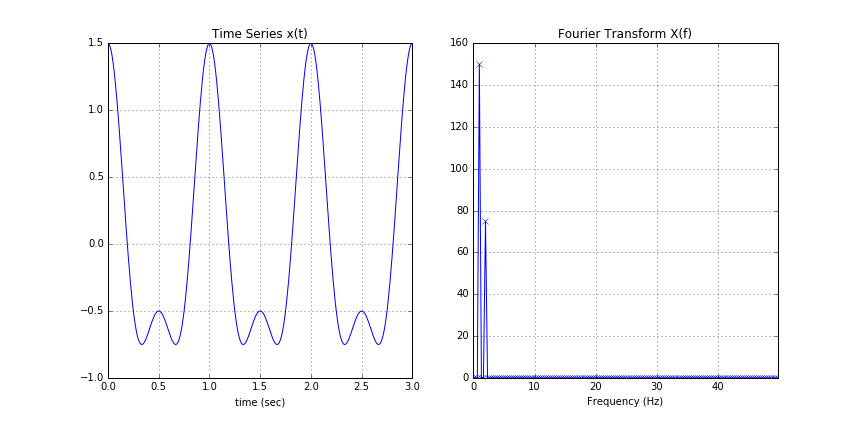

In [6]:
end_time=3
dt=0.01
t=np.arange(0,end_time,dt)
x=np.cos(2*np.pi*t)+0.5*np.cos(4*np.pi*t)
X=fft.fft(x)
freq=fft.fftfreq(len(t),dt)

#FFT is computed for both positive and *negative* frequencies.  For real-valued signals, the value of the FFT at 
#negative frequencies is the complex conjugate of the corresponding positive frequency value.  An artifact of the way 
#that the FFT is computed is that the negative frequencies are computed *after* the positive frequencies are.  
#The "fftshift" command re-orders the data so that negative frequencies occur before positive ones.
X=fft.fftshift(X)
freq=fft.fftshift(freq)

pl.figure(figsize=(12,6))
pl.subplot(121)
pl.plot(t,x)
pl.grid()
pl.title('Time Series x(t)')
pl.xlabel('time (sec)')


pl.subplot(122)

#In general, the Fourier transform is a sequence of *complex* numbers.  The magnitude of the Fourier transform provides
#an indication of how much energy is present in a signal at different frequencies, so that's what we'll plot here:
pl.plot(freq,np.abs(X),'-x')

#Only going to look at positive frequencies:
pl.xlim((0,freq[-1]))
pl.grid()
pl.title('Fourier Transform X(f)')
pl.xlabel('Frequency (Hz)')

FFT of Accelerometer Data
--

For our next example, we're going to compute the FFT of some accelerometer data, depicted below:

<IPython.core.display.Javascript object>


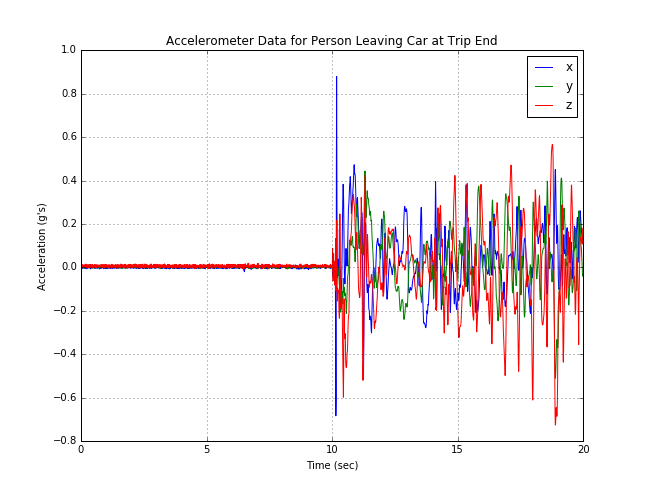

In [7]:
pl.figure(figsize=(9,7))
line1,line2,line3,=pl.plot(accel)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Accelerometer Data for Person Leaving Car at Trip End')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()

The data is taken at the end of a road trip.  During the first 10 seconds, the phone is stationary, and the during the next ten seconds, the user leaves the car and starts walking.  The accelerometer is *tri-axial*, meaning that it records acceleration data on a set three orthogonal axes as depicted below:

<img src='images/sensors-coordinates2.jpg' width="400">

Each of the three axes stores a separate time series.  We'll compute the FFT of just one axis for illustration.  

Note that walking motion is periodic in nature (you can see some periodicity in the time series above) and, therefore, we should expect to see some "spikes" in the Fourier transform at the users walking frequency and at *harmonics* integer multiples of the walking frequency.

<IPython.core.display.Javascript object>


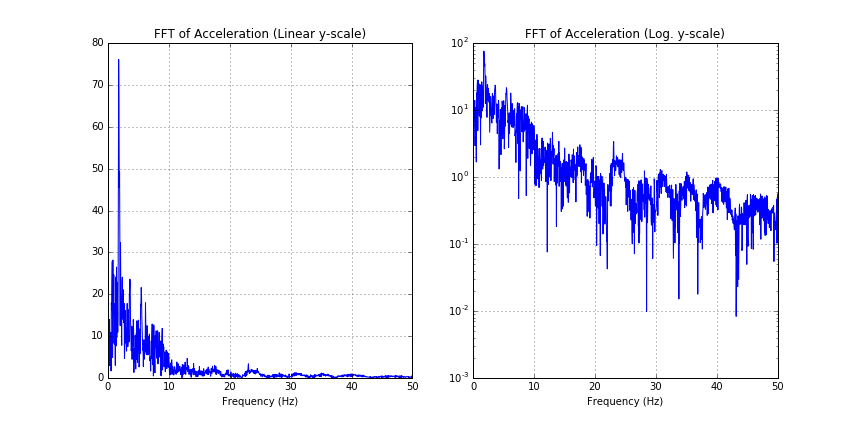

In [8]:
Accel=fft.fft(accel.z.values)
dt=np.diff(accel.index)[0]
f_vec=fft.fftfreq(len(Accel),dt)

#Make sure frequencies are in the right order.
Accel=fft.fftshift(Accel)
f_vec=fft.fftshift(f_vec)

pl.figure(figsize=(12,6))
ax1=pl.subplot(121)
pl.plot(f_vec,np.abs(Accel))
pl.xlim((0,f_vec[-1]))
pl.grid()
pl.title('FFT of Acceleration (Linear y-scale)')
pl.xlabel('Frequency (Hz)')
pl.subplot(122,sharex=ax1)
pl.semilogy(f_vec,np.abs(Accel))
pl.xlim((0,f_vec[-1]))
pl.grid()
pl.title('FFT of Acceleration (Log. y-scale)')
pl.xlabel('Frequency (Hz)')

<a id=butter></a>
Butterworth Filtering
===
For this next part, we're going to examine the *raw* acceleration recorded at the end of the same trip that we examined above.  The data is depicted below


<IPython.core.display.Javascript object>


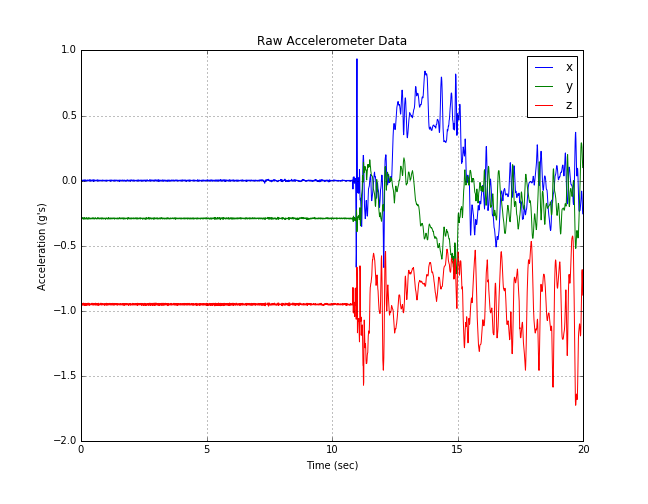

In [9]:
pl.figure(figsize=(9,7))
line1,line2,line3,=pl.plot(accel_raw)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Raw Accelerometer Data')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()

As noted in the slides, the raw acceleration is the sum of two components:  a *gravity* component and an *phon eacceleration* component:

$$a_m = g + a_d$$

(There were also a noise and bias component in the original equation, but we're going to assume that those are both negligible for the analysis performed here).

We are generally interested in separating out the gravity component from the phone acceleration component.  The phone acceleration provides us information about how the phone/car is behaving at different points of time, while the gravity component provides us with other important auxilliary information (it's a critical piece of information for estimating the orientation of the phone, for instance).  The proper way to separate out these two components is to use a *Kalman Filter*.  This type of filter utilizes information from the both the accelerometer and the gyroscope to estimate the gravity vector accurately.  The mechanics of these types of filters is significantly more complex than what we have time to describe here and, instead, we're going to investigate some approximate methods of quickly separating gravity from phone acceleration.

Our approximate way of separating gravity from the phone acceleration data will be to extract an estimate of gravity via a *lowpass* filter and to extract the remaining phone acceleration via a *highpass* filter.  There are a few reasons why a lowpass filter to extract a rough estimate of gravity from human walking activity is a reasonable approximation.  The first is that the gravity vector has significant changes only with significant changes in the orientation of the phone.  Such changes tend to happen infrequently and are, hence, low frequency events.  On the other hand, acceleration profiles for someone moving a phone tend to be "zero mean".  If there *were* a component of the acceleration that were constant while the user was walking with the phone, the lowpass filter would erroneously include that in the gravity estimate (indeed, this same technique is NOT a good idea when a car is actively accelerating or braking!).  But people tend to walk at constant speeds which, by definition, have zero net acceleration.  

Below, we're going to design lowpass and highpass *Butterworth filters* to extract an estimate of gravity and a 
separate estimate of phone acceleration.  In the code block below we:
1.  Design the filters and plot their weight functions $W(f)$,
2.  Apply the filters to the raw accelerometer data to extract our gravity and phone acceleration estimates, and
2.  Show how these filters affect the FFT of the raw accelerometer data when applied.


<IPython.core.display.Javascript object>


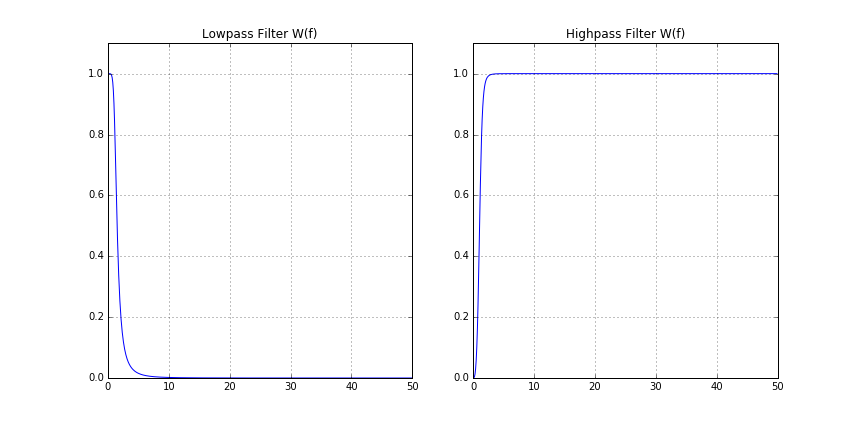

<IPython.core.display.Javascript object>


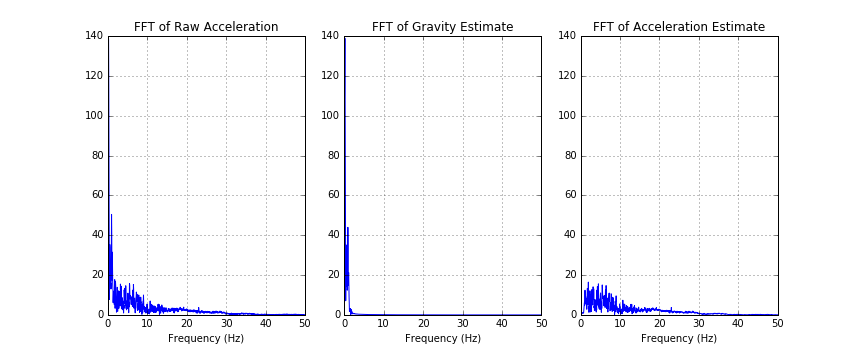

(0, 140.0)

In [10]:
f_cutoff=1.25 #frequency (in Hz) where we want our Butterworth Filter to start to transition.
f_s=100. #frequency (in Hz) which represents sample rate of data.

[b_low,a_low]=signal.filter_design.butter(3,2*f_cutoff/f_s,btype='lowpass')
[b_high,a_high]=signal.filter_design.butter(3,2*f_cutoff/f_s,btype='highpass')
#NOTE:  in practice don't need to both lowpass *and* highpass filter data, since the highpass-filtered data can be 
#obtained by subtracting the lowpass-filtered data from the original data.  Creating both filters here for 
#illustration only.

w,h_low=signal.freqz(b_low,a_low)
w,h_high=signal.freqz(b_high,a_high)

f_vec=w/np.pi*f_s/2.
pl.figure(figsize=(12,6))
pl.subplot(121)
pl.plot(f_vec,np.abs(h_low))
pl.ylim((0,1.1))
pl.grid()
pl.title('Lowpass Filter W(f)')
pl.subplot(122)
pl.plot(f_vec,np.abs(h_high))
pl.grid()
pl.ylim((0,1.1))
pl.title('Highpass Filter W(f)')

#Crude estimate of gravity:
grav_est=signal.filtfilt(b_low,a_low,accel_raw.values,axis=0)
grav_est=pd.DataFrame(data=grav_est,index=accel_raw.index,columns=['x','y','z'])

#Crude estimate of acceleration data
accel_est=signal.filtfilt(b_high,a_high,accel_raw.values,axis=0)
accel_est=pd.DataFrame(data=accel_est,index=accel_raw.index,columns=['x','y','z'])


#Plot Fourier Transforms of Original, Lowpass Filtered, and Highpass filtered data:

Accel_raw=fft.fft(accel_raw.x.values)
dt=np.diff(accel.index)[0]
f_vec=fft.fftfreq(len(Accel_raw),dt)

#Make sure frequencies are in the right order.
Accel_raw=fft.fftshift(Accel_raw)
f_vec=fft.fftshift(f_vec)

Grav_est=fft.fft(grav_est.x.values)
Grav_est=fft.fftshift(Grav_est)

Accel_est=fft.fft(accel_est.x.values)
Accel_est=fft.fftshift(Accel_est)

pl.figure(figsize=(12,5))
ax1=pl.subplot(131)
pl.plot(f_vec,np.abs(Accel_raw))
pl.xlim((0,f_vec[-1]))
pl.grid()
pl.title('FFT of Raw Acceleration')
pl.xlabel('Frequency (Hz)')
pl.subplot(132,sharex=ax1)
pl.plot(f_vec,np.abs(Grav_est))
pl.xlim((0,f_vec[-1]))
pl.grid()
pl.title('FFT of Gravity Estimate')
pl.xlabel('Frequency (Hz)')
ymax=pl.ylim()[1]
pl.subplot(133,sharex=ax1)
pl.plot(f_vec,np.abs(Accel_est))
pl.xlim((0,f_vec[-1]))
pl.grid()
pl.title('FFT of Acceleration Estimate')
pl.xlabel('Frequency (Hz)')
pl.ylim((0,ymax))

In the code block below, we plot the original raw accelerometer data, along with our gravity estimate and phone acceleration in the time domain (i.e., we're plotting the filtered time series).

<IPython.core.display.Javascript object>


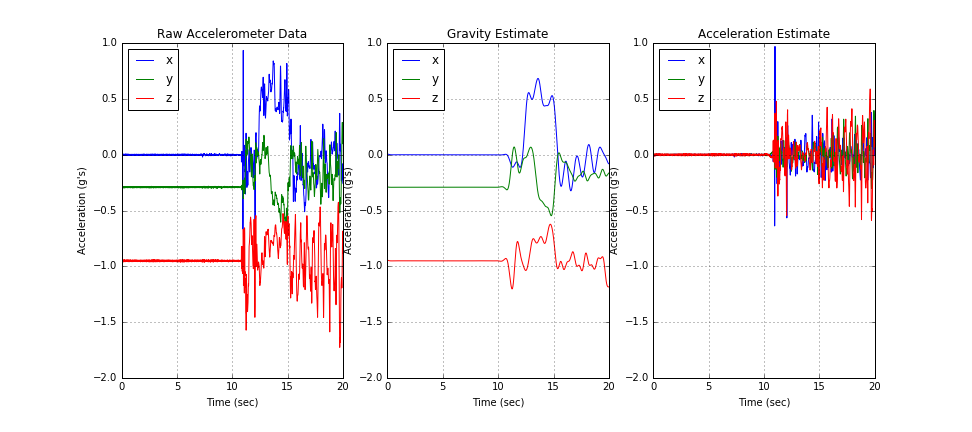

(-2.0, 1.0)

In [11]:
#Plot original and filtered data
pl.figure(figsize=(13.5,6))
ax1=pl.subplot(131)
line1,line2,line3,=pl.plot(accel_raw)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Raw Accelerometer Data')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()
y_lim=pl.ylim()

ax1=pl.subplot(132)
line1,line2,line3,=pl.plot(grav_est)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Gravity Estimate')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()
pl.ylim(y_lim)

ax1=pl.subplot(133)
line1,line2,line3,=pl.plot(accel_est)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Acceleration Estimate')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()
pl.ylim(y_lim)

Quality of Estimates
--
How good are the estimates of gravity and phone acceleration?  One way to check here is to compare our estimated phone acceleration to the processed phone acceleration recorded by the Iphone, which is the data we originally looked at in our FFT example.  Below, we plot our estimate and the iPhone's estimate of phone acceleration side-by-side.

<IPython.core.display.Javascript object>


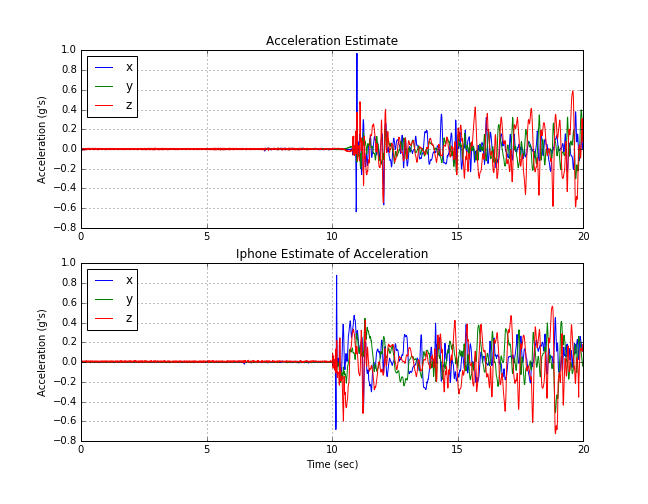

In [12]:
pl.figure(figsize=(9,7))
ax1=pl.subplot(211)
line1,line2,line3,=pl.plot(accel_est)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Acceleration Estimate')
pl.ylabel('Acceleration (g\'s)')
pl.grid()

pl.subplot(212,sharex=ax1)
line1,line2,line3,=pl.plot(accel)
pl.legend([line1,line2,line3],['x','y','z'],loc=0)
pl.title('Iphone Estimate of Acceleration')
pl.ylabel('Acceleration (g\'s)')
pl.xlabel('Time (sec)')
pl.grid()


The biggest difference to note is that there is an apparent *time shift* between our estimate of the phone acceleration and the iPhone's estimate.  This is not caused by the filtration process (some filters can cause a time delay, but the filters implemented here are *zero phase* and cannot do this) but, rather, is due to the fact that different portions of the iPhone core motion processor report raw acceleration and processed acceleration, and there is sometimes a time shift between when these two quantities get reported out. 

Other than the time shift, the salient features between our estimate and the iPhone's estimate, which uses the more complicated Kalman Filter that we mentioned at the beginning of this section, are on par.  And from a data scientist's perspective, all of the filtering and plotting operations were able to be performed almost instantaneously.  These filtering tools are, therefore, easy to implement in just a few lines of code and very quick to run experiments with!

Time Delay Estimation
--

As a parting thought, it turns out that the estimate of phone acceleration produced above can be used in conjunction with the iPhone's estimate of phone acceleration to accurately detect the time delay between the two waveforms.  To do so, we use a class of filtering techniques called *cross-correlation* techniques to correlate time-shifted versions of one of the time series against the other.  The time shift where the two time series best align creates a huge "spike* in correlation compared to other time shifts and is used as an estimate of the time shift between the two waveforms.  In experiments we've performed with similar end-of-trip data, the time estimate produced in this manner is often *very* accurate.